## Business Problem
1. To develop a model for ACME Real Estate Agency to accurately predict a value of a house based on avaliable data. This will help their clients, either buy or sell their homes at a fair price.
2. To identify if renovations can be made to improve the selling price of the house.

## Methodology
By developing using a Linear Regression model, we will try to predict the selling price of a house based on attributes like size, number of bedrooms/bathroorms etc. WE will also try to minimize the RMSE value to achieve maximum efficiency.

## Dataset
Dataset used will be the King County House Sales dataset : `kc_house_data.csv`

## EDA

In [20]:
#importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [21]:
#importing files
#getting the file from the github repo
url = 'https://raw.githubusercontent.com/rahulakrish/real_estate_analysis/main/kc_house_data.csv'
df = pd.read_csv(url)

#checking the df
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


Gathering some info about the df:

In [22]:
print(f'Size of the dataframe is {df.shape}')
print('\n')
df.info()

Size of the dataframe is (21613, 21)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat        

We can see that there is a reasonable amount of data for us to work with.

In [23]:
#dropping the id column since it is irrelevant
df.drop(columns='id',axis=1,inplace=True)

Checking for missing data:

In [24]:
df.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       2
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

We can impute the median for the missing values in sqft_above. Since median is the actual mid-point of the data and unaffected by outlliers, it is a safe choice:

In [25]:
#imputing the median value
df['sqft_above'].fillna(df['sqft_above'].median,inplace=True)

#checking to see if it worked
df.isna().sum().value_counts()

0    20
dtype: int64

In [27]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

Since linear regression performs better with normally distributed variables, let's check to see how the variables are distributed. This will also help us discern if we need apply other pre-processing steps like scaling,    log-transformation etc.

This can be done with a simple line of code using Pandas:

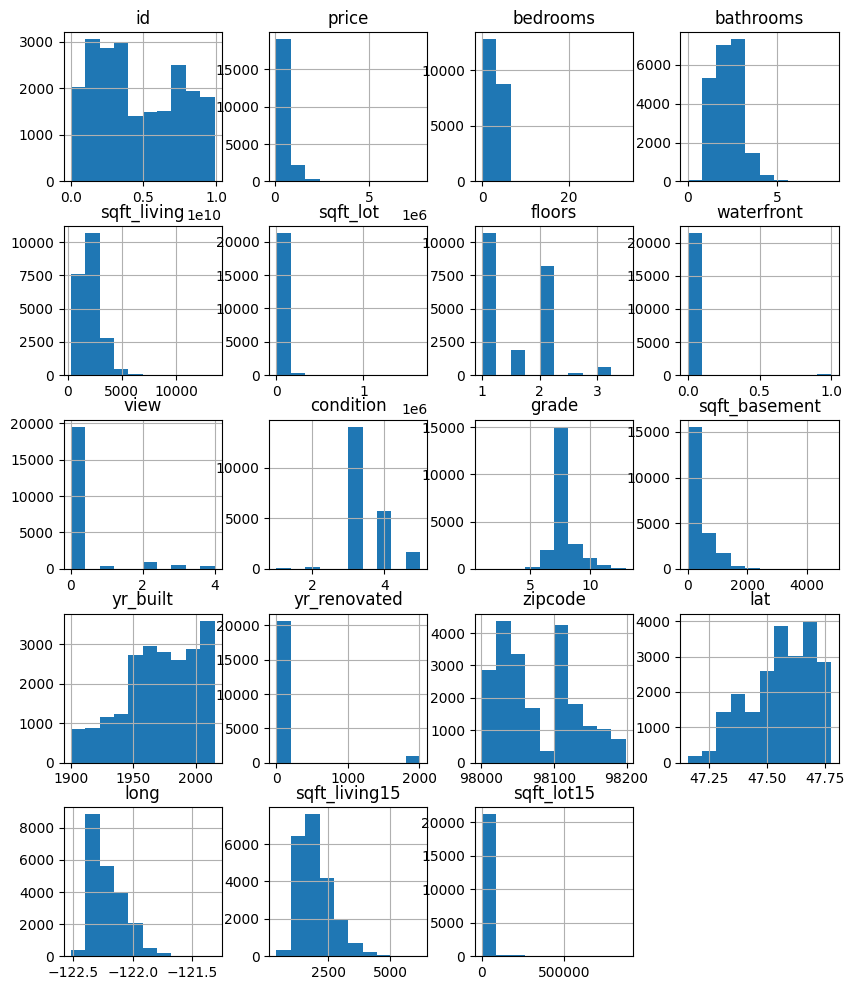

In [8]:
pd.plotting.hist_frame(df,figsize=(10,12));

Couple of things to note from the plot:
1. None of the features are normally distributed.
2. The magnitiudes between the features differs considerably. Left unchanged, this would cause the co-efficients to fluctuate as well. This could lead to false impressions that some features are more important than others.

Let's first tranform the features to make them normal. One way to do so is by doing a Log transformation of the data. This can also help reduce skewness and reduce variability in the data.

In [10]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
print('R-squared value for the baseline_model = ',model_baseline.rsquared)
print('R-squared value for model_1 = ',model_1.rsquared, ' - removing yr_renovated ')
print(f'R-squared value for model_2 = ',model_2.rsquared, ' - transforming price using log transform')

R-squared value for the baseline_model =  0.700927956381505
R-squared value for model_1 =  0.7005211415851306  - removing yr_renovated 
R-squared value for model_2 =  0.7715173571062647  - transforming price using log transform
